### Week 5: Digital Humanities 

In [94]:
import pandas as pd
import numpy as np; np.random.seed(1)  # fix a seed for reproducible random sampling
import matplotlib.pyplot as plt
import scipy.special
import itertools
import re

In [2]:
words_of_interest = ['upon', 'the', 'state', 'enough', 'while', 'any', 'his', 'were','to']
df = pd.read_csv('data/federalist-papersNew2.csv', index_col=0)
print(len(df))
df[words_of_interest].sample(6)


85


,upon,the,state,enough,while,any,his,were,to
39,0,300,12,0,0,4,1,6,91
45,0,278,18,0,0,4,1,6,66
28,3,166,13,0,0,2,0,2,66
41,0,336,3,0,0,6,3,6,119
37,1,230,5,0,0,3,5,3,85
81,13,389,26,0,2,15,0,3,163


In [3]:

disputed_essays = df[df['AUTHOR'] == 'Hamilton OR Madison'].index
assert len(disputed_essays) == 12  # there are twelve disputed essays
# numbers widely used to identify the essays
assert set(disputed_essays) == {49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63}

In [4]:
df_known = df.loc[df['AUTHOR'].isin(('Hamilton', 'Madison'))]
print(df_known['AUTHOR'].value_counts())

Hamilton    51
Madison     14
Name: AUTHOR, dtype: int64


In [5]:
# df_known.groupby('AUTHOR')['upon'].describe()

In [6]:
# df_known.groupby('AUTHOR')['upon'].head()
# df_known.groupby('AUTHOR')['upon'].tail()
df_known.groupby('AUTHOR')['upon'].sum()

AUTHOR
Hamilton    374
Madison       7
Name: upon, dtype: int64

#### Q1. Considering the words ‘to’, ‘upon’ and ‘would’, draw a graph representing the occurrences of those words in Hamilton and Madison’s articles.

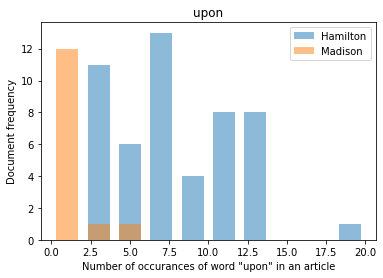

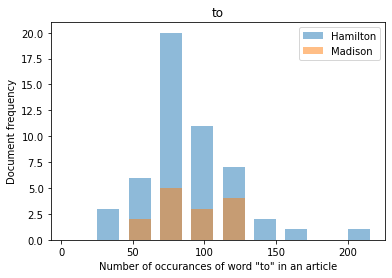

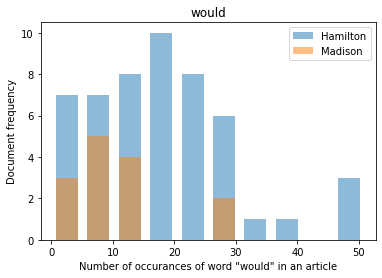

In [7]:
for word in ['upon','to','would']:
    
    maxwordcount = df_known[word].max()
    df_known.groupby('AUTHOR')[word].plot.hist(rwidth=0.7,alpha=0.5, range=(0, maxwordcount), legend=True)
#     hamilton = df_known.loc[df_known['AUTHOR'] == 'Hamilton']
#     print(hamilton.head(5))
#     print(hamilton['upon'])
    plt.title(word)
    plt.xlabel('Number of occurances of word "{}" in an article'.format(word))
    plt.ylabel('Document frequency')

    plt.show()


#### Q2. With these three words, model them as a binomial to reflect either occurrences in Hamilton or Madison’s writing style.

#### Q3. Represent with a histogram the article length. Does it make sense to view this distribution as a Gaussian?

In [8]:

print("Original Cols length: {}".format(len(df.columns)))

all_word_cols = []
for col in df.columns:
    k= re.findall('[a-z]+', col,re.I)
    if k != []:
        all_word_cols.append(col)
print("Processed word tokens length: {}".format(len(all_word_cols)))

Original Cols length: 11501
Processed word tokens length: 11275


<AxesSubplot:>

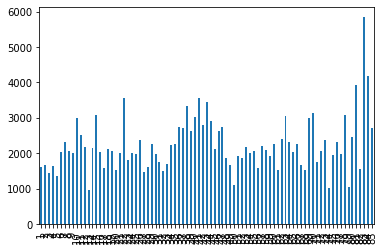

In [9]:
edited_rows = df[all_word_cols]
#edited_rows.head()
count_of_tokens = edited_rows.sum(axis=1)
count_of_tokens.plot(x= df, kind ='bar')


### Problem 2: Processing the text

In [88]:
# Loading 
sms_text = pd.read_csv('corpus/sms_spam.csv', delimiter=",")
sms_text.head(5)

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


#### Q1. Transform the text to lowercase

In [89]:
sms_text['text'] = sms_text['text'].str.lower()
sms_text.head(5)

,type,text
0,ham,hope you are having a good week. just checking in
1,ham,k..give back my thanks.
2,ham,am also doing in cbe only. but have to pay.
3,spam,"complimentary 4 star ibiza holiday or £10,000 ..."
4,spam,okmail: dear dave this is your final notice to...


#### Q2. Normalize the tokens (replace the English contraction by their equivalent such ‘can’t’ -> ‘can not’)

In [106]:
sms_text['text'] = sms_text['text'].replace("n't", " not")
sms_text['text'] = sms_text['text'].replace("ll", " will")
sms_text['text'] = sms_text['text'].replace("can't", "can not")
sms_text.head(5)
# mean = "i can't do it"
# st = mean.replace("n't", " not")
# st

,type,text
0,ham,hope you are having a good week. just checking in
1,ham,k..give back my thanks.
2,ham,am also doing in cbe only. but have to pay.
3,spam,"complimentary 4 star ibiza holiday or £10,000 ..."
4,spam,okmail: dear dave this is your final notice to...


#### Q3. Be able to read a list of stopwords and to remove them when they appear in the text (two such lists are given in the folder ‘Corpus’).

In [107]:
stop_words_1 = np.loadtxt('corpus/stopwords.txt', dtype='str')
#stop_words_1

In [108]:
sms_text1 = sms_text.copy()

for index,sms in enumerate(sms_text1['text']):
    token_without_sw = [word for word in sms.split(" ") if not word in stop_words_1]
    sms = (" ").join(token_without_sw)
    sms_text1['text'][index] = sms 
sms_text1.head(5)


,type,text
0,ham,hope good week. checking
1,ham,k..give back thanks.
2,ham,also cbe only. pay.
3,spam,"complimentary 4 star ibiza holiday £10,000 cas..."
4,spam,okmail: dear dave final notice collect 4* tene...


In [109]:
stop_words_2 = np.loadtxt('corpus/StopwordSMART.txt', dtype='str')
#print(stop_words_2)

sms_text2 = sms_text1.copy()

for index,sms in enumerate(sms_text2['text']):
    token_without_sw = [word for word in sms.split(" ") if not word in stop_words_2]
    sms = (" ").join(token_without_sw)
    sms_text2['text'][index] = sms 
print(sms_text2.head(5))

   type                                               text
0   ham                           hope good week. checking
1   ham                               k..give back thanks.
2   ham                                     cbe only. pay.
3  spam  complimentary 4 star ibiza holiday £10,000 cas...
4  spam  okmail: dear dave final notice collect 4* tene...


#### Q4. Apply your preprocessing to both the spam and ham SMSs. Return the top 20 most frequent word-types for both categories

In [117]:
ham_tokens = sms_text2.loc[sms_text2['type'] == 'ham']
print("Total hams: ",len(ham_tokens))
print(ham_tokens['text'].head(5))
spam_tokens = sms_text2.loc[sms_text2['type'] == 'spam']
print("Total Spams:",len(spam_tokens))

Total hams:  4812
0          hope good week. checking
1              k..give back thanks.
2                    cbe only. pay.
5    aiya discuss lar... pick 4 it?
6                              buzy
Name: text, dtype: object
Total Spams: 747


In [124]:
frequent_word = ""
frequency = 0 
words = []

for i, words in enumerate(ham_tokens['text']):
    total_words = words.split(" ")
    print(total_words)
    for w in [total_words]: 
        words.append(w)
    print(len(words))
        

['hope', 'good', 'week.', 'checking']


AttributeError: 'str' object has no attribute 'append'